# 02b - Mean-Gradient Forced Scalar Evolution

Demonstrates the recommended workflow: start from a smooth scalar field and apply a mean-gradient forcing to maintain a stationary cascade.

**Focus**
- Build a velocity field suitable for mixing statistics
- Initialise a smooth (uniform) scalar field
- Apply mean-gradient forcing during ETDRK4 integration
- Inspect snapshots, spectra, and dissipation diagnostics

In [1]:
import sys, pathlib
project_root = pathlib.Path().resolve()
if not (project_root / 'scalar_advection').exists():
    for parent in project_root.parents:
        if (parent / 'scalar_advection').exists():
            project_root = parent
            break
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scalar_advection import (
    ScalarAdvectionAPI,
    VelocityConfig,
    ScalarConfig,
    structure_functions,
    plot_structure_functions,
    generate_divfree_field
)

import cmasher as cmr

In [4]:
# Configure FFT threading per notebook session (adjust as needed).
ScalarAdvectionAPI.set_fft_threads(8)


> **Tips:**
> - To trade a little spectral accuracy for speed, re-instantiate `ScalarAdvectionAPI` with `dtype=np.float32` and set `VelocityConfig(precision='float32')`.
> - For cheaper time-stepping, set `ScalarConfig(..., integrator='rk4')` or `'heun'` to use explicit Runge–Kutta variants.

## Simulation configuration

In [40]:
N = 1024
api = ScalarAdvectionAPI(N=N, L=1.0, warm_cache=True)
api.warm_fft_cache()

velocity_config = VelocityConfig(beta=5/3, urms=1.0, seed=5, kmin=2, kmax=N//2)
ux, uy = api.generate_velocity(velocity_config)

### Velocity magnitude

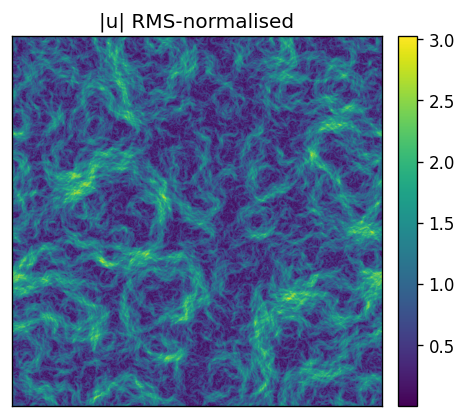

In [41]:
speed = np.hypot(ux, uy)
plt.figure(figsize=(4.5, 4), dpi=120)
im = plt.imshow(speed, origin='lower', cmap='viridis')
plt.title('|u| RMS-normalised')
plt.xticks([]); plt.yticks([])
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

# run the simulation

In [42]:
# Smooth initial scalar: uniform field (all zeros)
theta0 = np.zeros((N, N), dtype=api.grid.dtype)

scalar_config = ScalarConfig(
    peclet=32768,
    t_end=0.25,
    mean_grad=(1.0, 0.0),
    save_every=500,
    frame_interval=0.25,
    output_frames=True,
    integrator='rk4',
    cfl=0.6
)
theta_final, diagnostics = api.evolve_scalar(theta0, ux, uy, scalar_config, verbose=False)

### Diagnostic overview

In [43]:
print(f'Time steps: {diagnostics.n_steps}')
print(f'Delta t: {diagnostics.dt:.4e}')
print(f'Diffusivity kappa: {diagnostics.kappa:.3e}')
print(f'Mean gradient forcing: {scalar_config.mean_grad}')
print(f'Snapshots stored: {len(diagnostics.snapshots)}')
print(f'Frame stack available: {diagnostics.frames is not None}')

Time steps: 2534
Delta t: 9.8658e-05
Diffusivity kappa: 3.052e-05
Mean gradient forcing: (1.0, 0.0)
Snapshots stored: 7
Frame stack available: True


### Scalar snapshots (forced evolution)

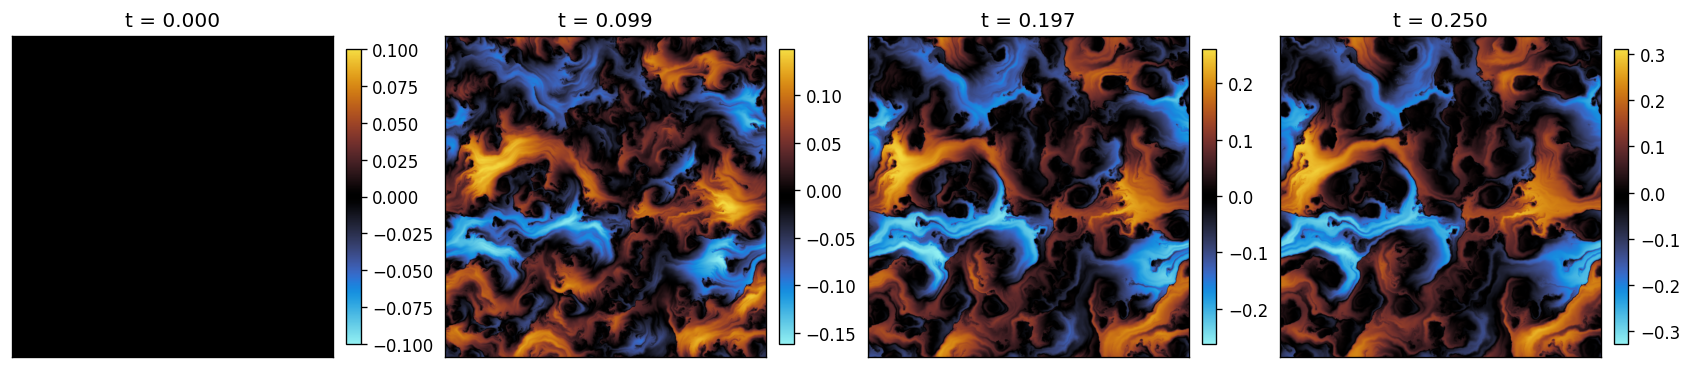

In [44]:
if diagnostics.snapshots:
    idxs = np.linspace(0, len(diagnostics.snapshots) - 1, 4, dtype=int)
    fig, axs = plt.subplots(1, len(idxs), figsize=(14, 3.5), dpi=120, constrained_layout=True)
    for ax, idx in zip(axs, idxs):
        im = ax.imshow(diagnostics.snapshots[idx], origin='lower', cmap=cmr.iceburn)
        ax.set_title(f't = {diagnostics.times[idx]:.3f}')
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()
else:
    print('No in-memory snapshots. Increase save_every to store fields.')

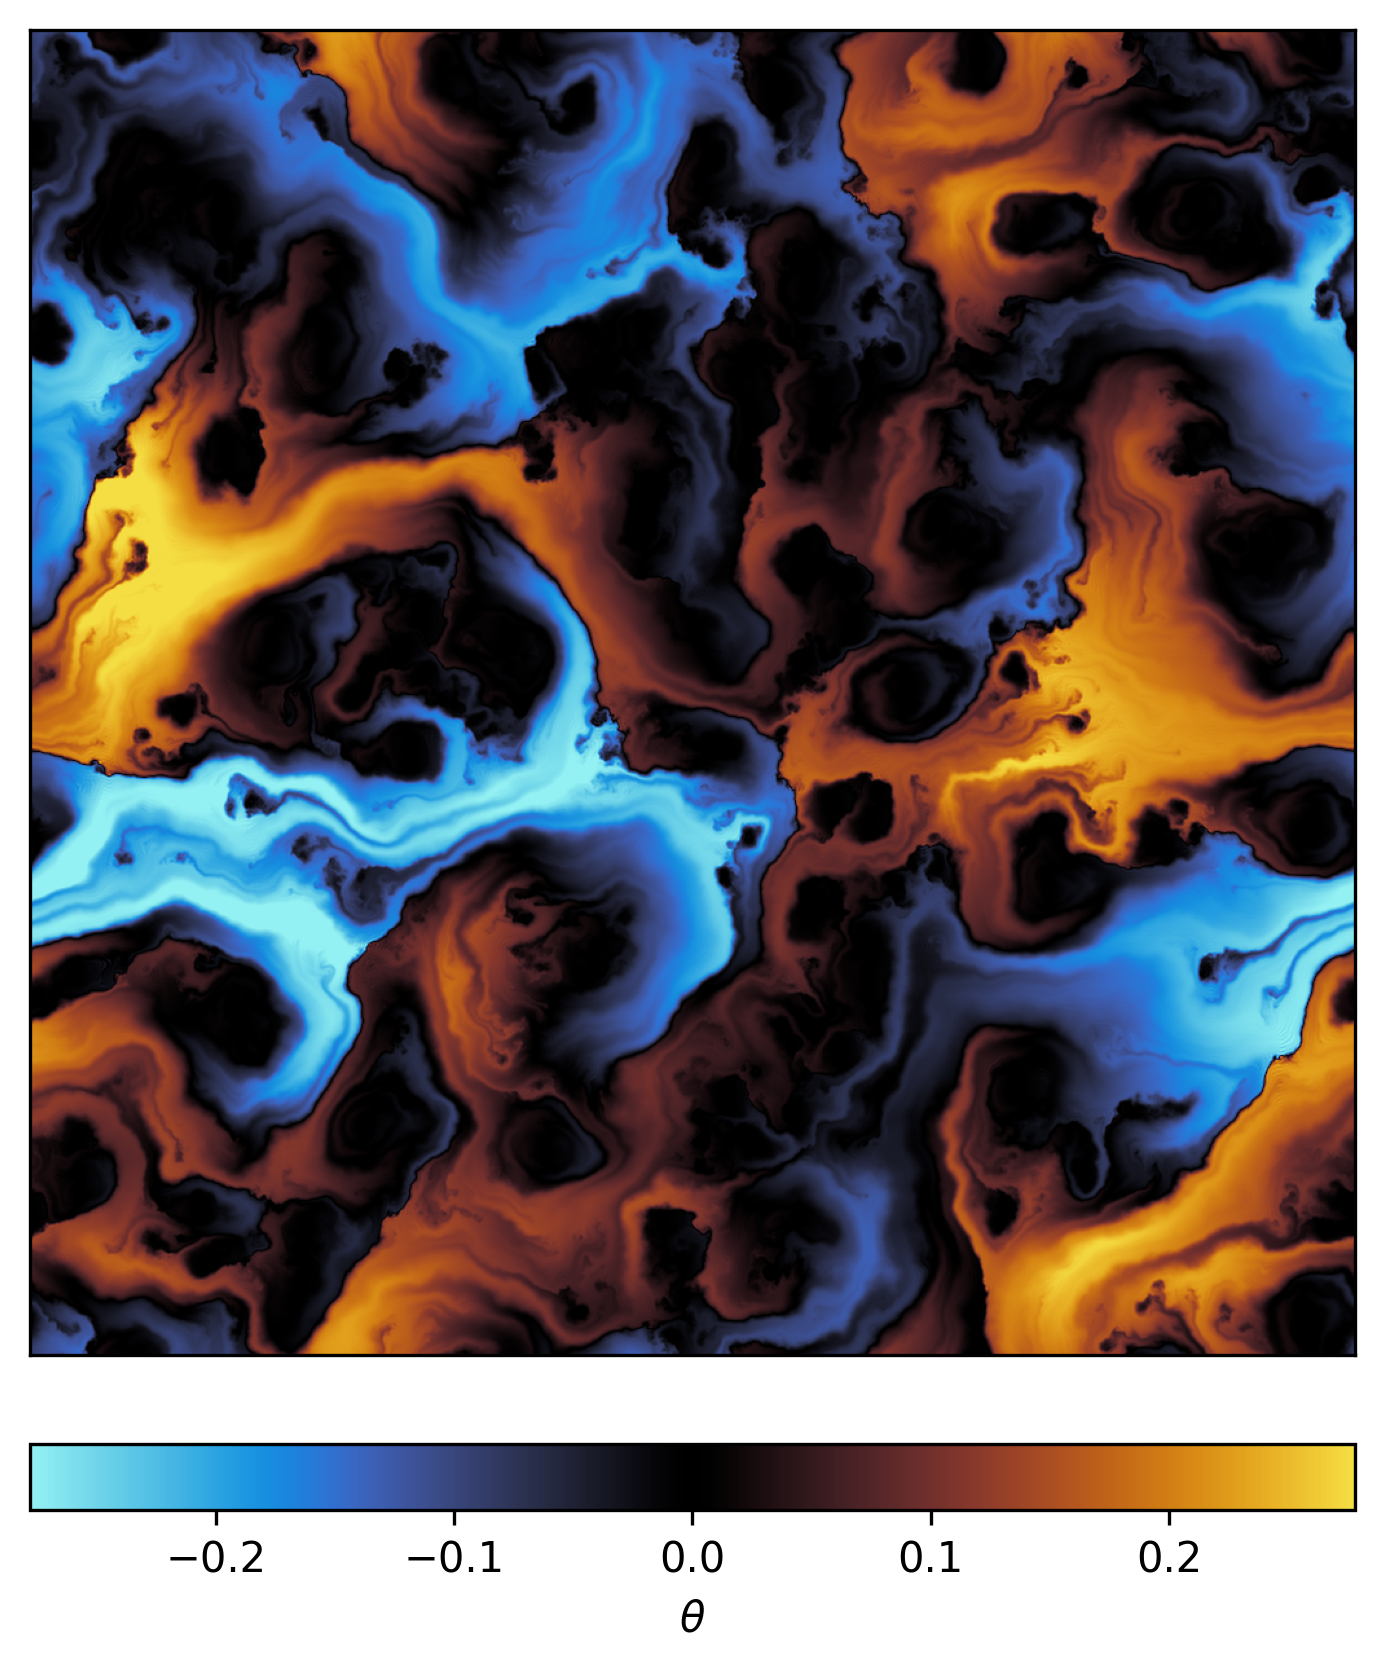

In [45]:
plt.figure(figsize=(4.5, 6), dpi=300, constrained_layout=True)
im = plt.imshow(theta_final, origin='lower', cmap=cmr.iceburn, vmin=-np.percentile(np.abs(theta_final), 99), vmax=np.percentile(np.abs(theta_final), 99))
plt.xticks([]); plt.yticks([])
cb = plt.colorbar(im, location='bottom')
cb.set_label(r'$\theta$')
plt.show()

### Scalar spectra and dissipation

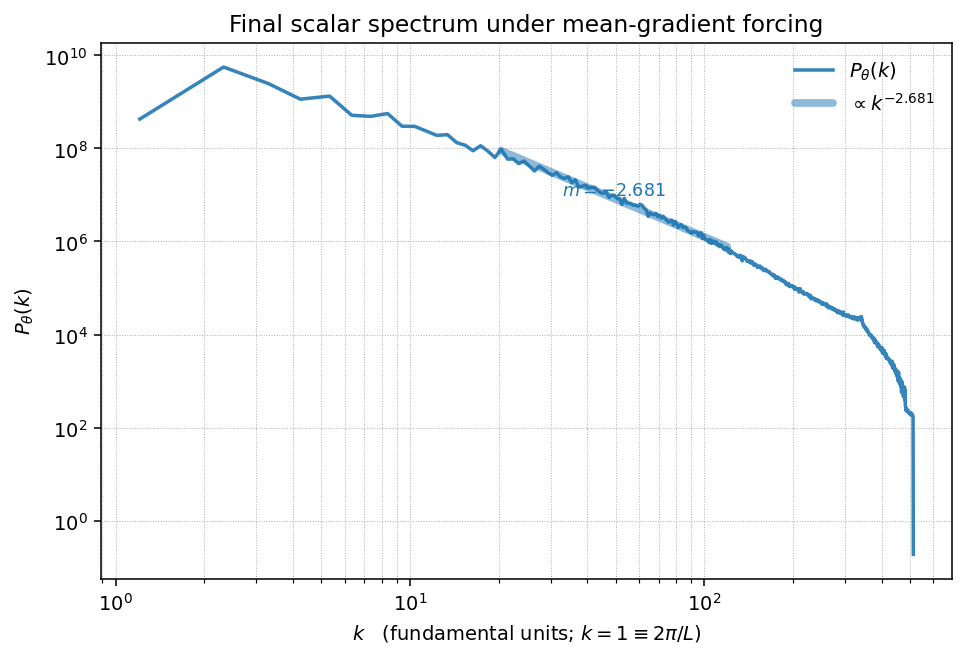

Scalar dissipation rate χ = 7.384e-03


In [46]:
k_final, E_final = api.scalar_spectrum(theta_final)
ScalarAdvectionAPI.plot_scalar_spectrum(
    k_final,
    E_final,
    title='Final scalar spectrum under mean-gradient forcing',
    annotate_fit=True,
    fit_min_decades=0.75,
    fit_min_k=4.0,
    fit_max_k=k_final.max() / 4,
)

chi = api.scalar_dissipation(theta_final, diagnostics.kappa)
print(f'Scalar dissipation rate χ = {chi:.3e}')

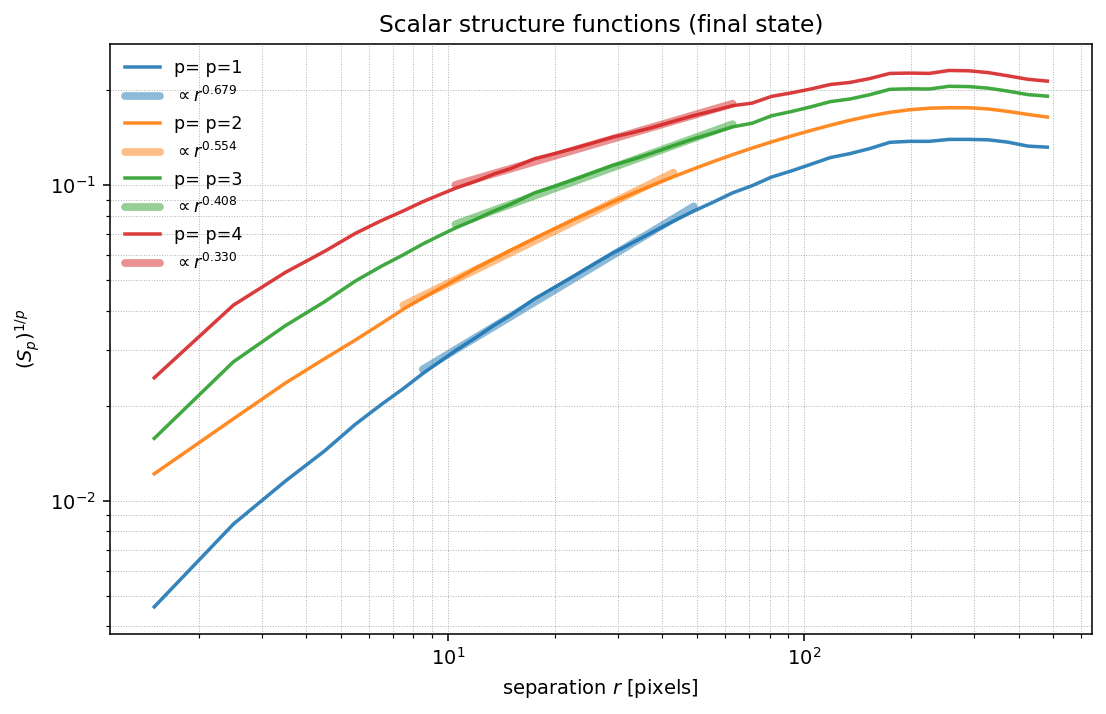

In [47]:
orders = (1, 2, 3, 4)
sf_scalar = api.scalar_structure_functions(
    theta_final, orders=orders, n_ell_bins=40, n_disp_total=4096, seed=0
)
plot_structure_functions(
    sf_scalar,
    title='Scalar structure functions (final state)',
    plot_long_and_tran=False,
    fit_min_r=4.0,
    fit_max_r=64.0,
    fit_min_decades=0.75,
)

Mean-gradient forcing continually injects scalar variance while the flow mixes it, leading to a statistically stationary balance. Use this notebook as the baseline configuration for production runs.

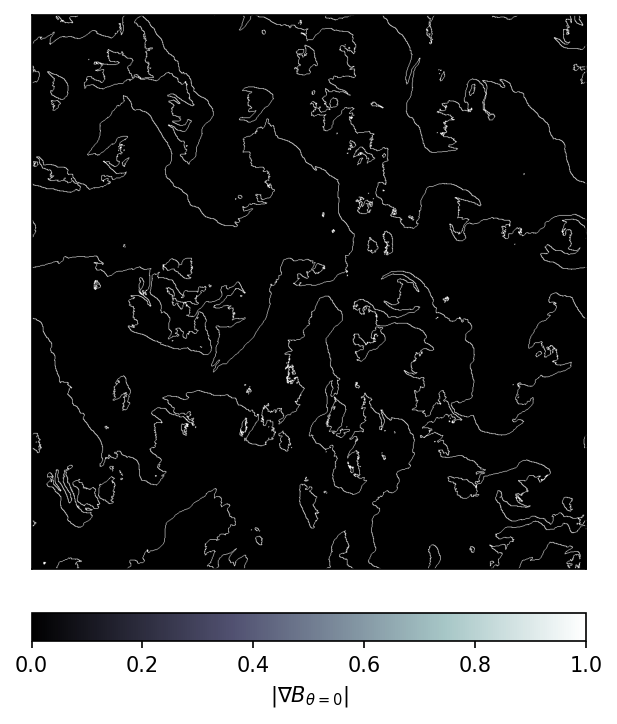

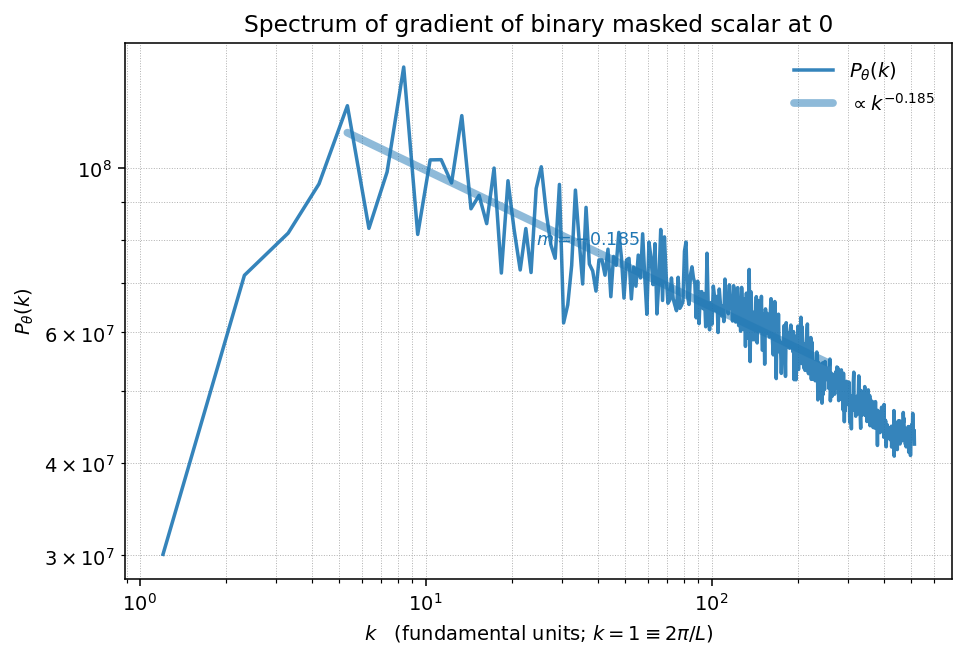

In [48]:
theta_masked = np.ones_like(theta_final)
theta_masked[theta_final<0] = 0
dtheta_masked = ((theta_masked - np.roll(theta_masked,1,axis=0))**2 + (theta_masked - np.roll(theta_masked,1,axis=1))**2)**0.5
dtheta_masked[dtheta_masked>0] = 1
fig, ax = plt.subplots(1,1, dpi=150, constrained_layout=True, figsize=(4,6))
im = ax.imshow(dtheta_masked, cmap='bone')
ax.set_xticks([])
ax.set_yticks([])
cb = plt.colorbar(im, location='bottom')
cb.set_label(r"$|\nabla B_{\theta=0}|$")
plt.show()


k_final, E_final = api.scalar_spectrum(dtheta_masked)
ScalarAdvectionAPI.plot_scalar_spectrum(
    k_final,
    E_final,
    title='Spectrum of gradient of binary masked scalar at 0',
    annotate_fit=True,
    fit_min_decades=1.2,
    fit_min_k=4.0,
    fit_max_k=k_final.max() / 2,
)

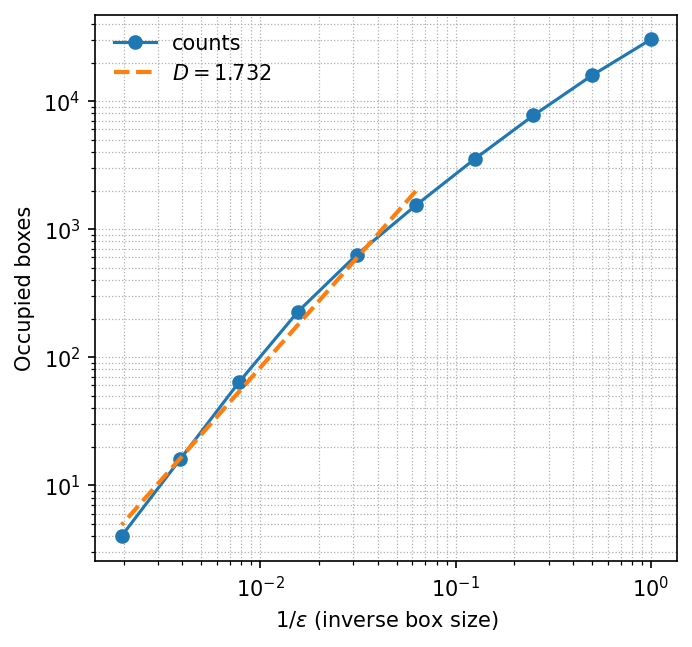

Box-counting fractal dimension D = 1.7323


In [49]:
box_result = api.box_counting(
    dtheta_masked,
    min_box=1,
    max_box=N // 2,
    fit_min_size=8,
    fit_max_size=N//2,
    fit_min_decades=1.5
)
sizes = box_result.box_sizes.astype(float)
counts = box_result.counts
inv_sizes = 1.0 / sizes
fig, ax = plt.subplots(figsize=(4.5, 4.2), dpi=150, constrained_layout=True)
ax.loglog(inv_sizes, counts, 'o-', lw=1.5, label='counts')
if box_result.slope is not None and box_result.fit_indices is not None:
    i0, i1 = box_result.fit_indices
    x_fit = inv_sizes[i0:i1]
    slope = box_result.slope
    intercept = box_result.intercept
    ax.loglog(x_fit, 10**(intercept) * x_fit**slope, '--', lw=2, label=rf'$D={slope:.3f}$')
ax.set_xlabel(r'$1/\epsilon$ (inverse box size)')
ax.set_ylabel('Occupied boxes')
ax.grid(True, which='both', ls=':', lw=0.6)
ax.legend(frameon=False)
plt.show()
if box_result.slope is not None:
    print(f'Box-counting fractal dimension D = {box_result.slope:.4f}')
else:
    print('Box-counting fit unavailable (insufficient scale range).')

# Wavelet based

In [52]:
N = 1024
api_wavelet = ScalarAdvectionAPI(N=N, L=1.0, dtype=np.float32, warm_cache=True)

ux_wavelet, uy_wavelet, speed_wavelet = generate_divfree_field(
    N=N,
    lam_min=6,
    lam_max=N // 2,
    slope=-5/3,
    wavelet='mexh',
    sparsity=0.0,
    seed=42,
)
ux_wavelet = ux_wavelet.astype(api_wavelet.grid.dtype, copy=False)
uy_wavelet = uy_wavelet.astype(api_wavelet.grid.dtype, copy=False)


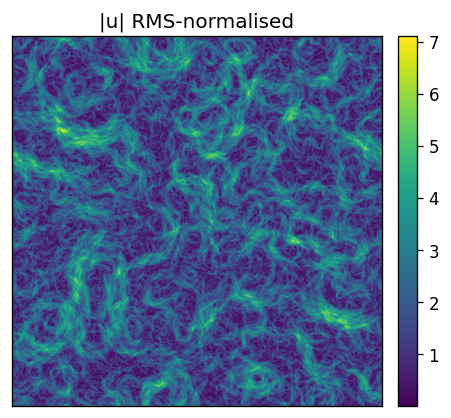

In [53]:
speed = np.hypot(ux_wavelet, uy_wavelet)
plt.figure(figsize=(4.5, 4), dpi=120)
im = plt.imshow(speed, origin='lower', cmap='viridis')
plt.title('|u| RMS-normalised')
plt.xticks([]); plt.yticks([])
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [55]:
theta0_wavelet = np.zeros((N, N), dtype=api_wavelet.grid.dtype)
scalar_config_wavelet = ScalarConfig(
    peclet=32768,
    t_end=0.25,
    mean_grad=(1.0, 0.0),
    save_every=500,
    frame_interval=0.25,
    output_frames=True,
    integrator='rk4',
    cfl=0.75,
)

theta_wavelet, diagnostics_wavelet = api_wavelet.evolve_scalar(
    theta0_wavelet, ux_wavelet, uy_wavelet, scalar_config_wavelet, verbose=False
)

diagnostics_wavelet.n_steps

4268

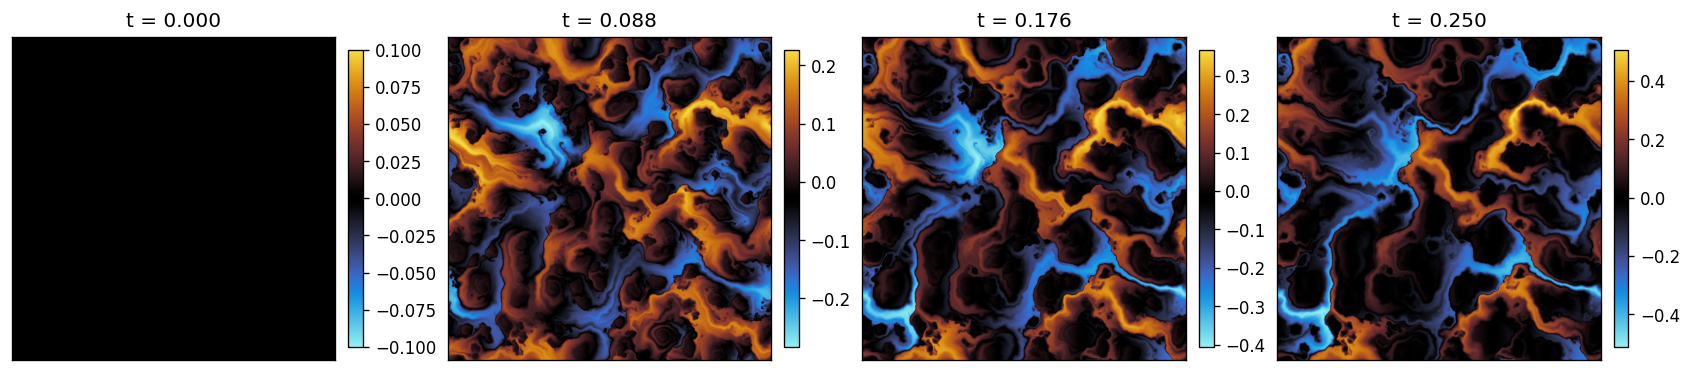

In [56]:
if diagnostics_wavelet.snapshots:
    idxs = np.linspace(0, len(diagnostics_wavelet.snapshots) - 1, 4, dtype=int)
    fig, axs = plt.subplots(1, len(idxs), figsize=(14, 3.5), dpi=120, constrained_layout=True)
    for ax, idx in zip(axs, idxs):
        im = ax.imshow(diagnostics_wavelet.snapshots[idx], origin='lower', cmap=cmr.iceburn)
        ax.set_title(f't = {diagnostics_wavelet.times[idx]:.3f}')
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()
else:
    print('No in-memory snapshots. Increase save_every to store fields.')

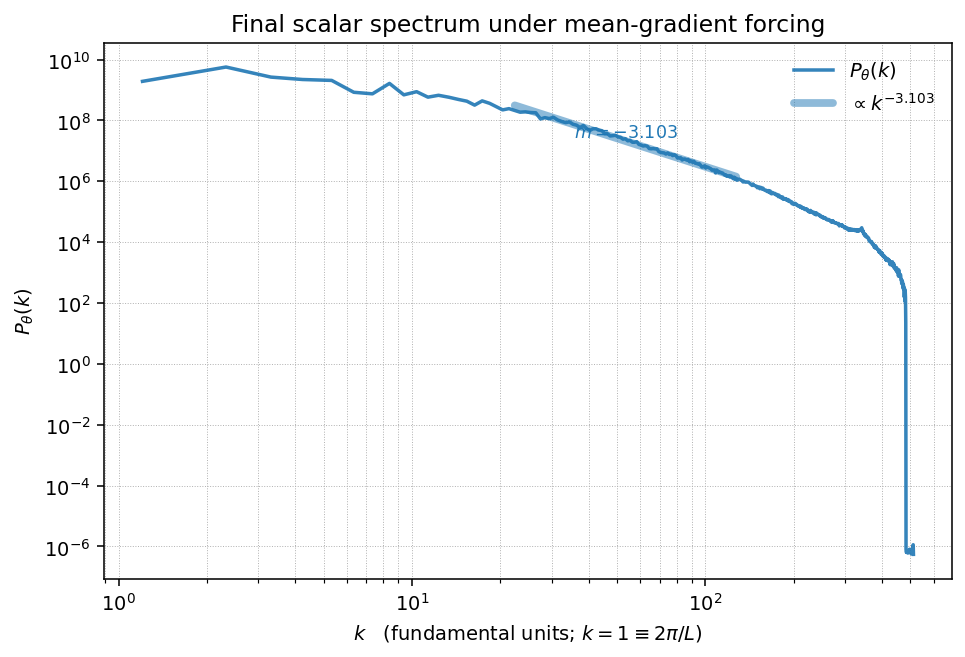

Scalar dissipation rate χ = 1.948e-02


In [57]:
k_final, E_final = api.scalar_spectrum(theta_wavelet)
ScalarAdvectionAPI.plot_scalar_spectrum(
    k_final,
    E_final,
    title='Final scalar spectrum under mean-gradient forcing',
    annotate_fit=True,
    fit_min_decades=0.75,
    fit_min_k=4.0,
    fit_max_k=k_final.max() / 4,
)

chi = api.scalar_dissipation(theta_wavelet, diagnostics.kappa)
print(f'Scalar dissipation rate χ = {chi:.3e}')

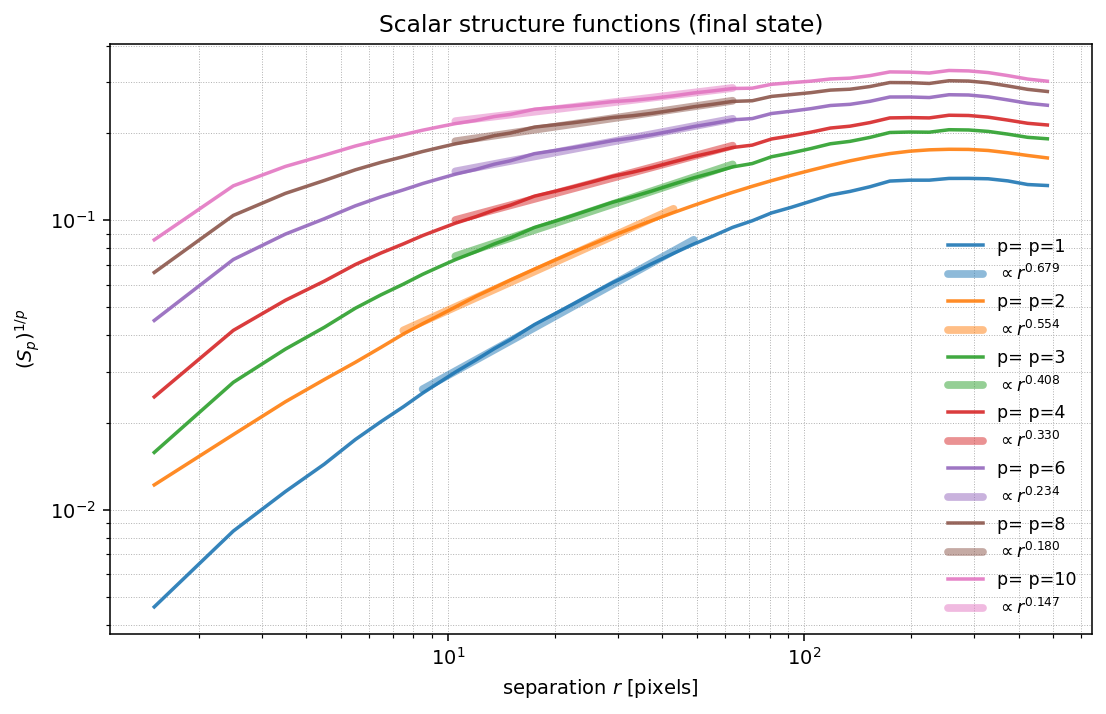

In [58]:
orders = (1, 2, 3, 4, 6, 8, 10)
sf_scalar = api.scalar_structure_functions(
    theta_final, orders=orders, n_ell_bins=40, n_disp_total=4096, seed=0
)
plot_structure_functions(
    sf_scalar,
    title='Scalar structure functions (final state)',
    plot_long_and_tran=False,
    fit_min_r=4.0,
    fit_max_r=64.0,
    fit_min_decades=0.75,
)

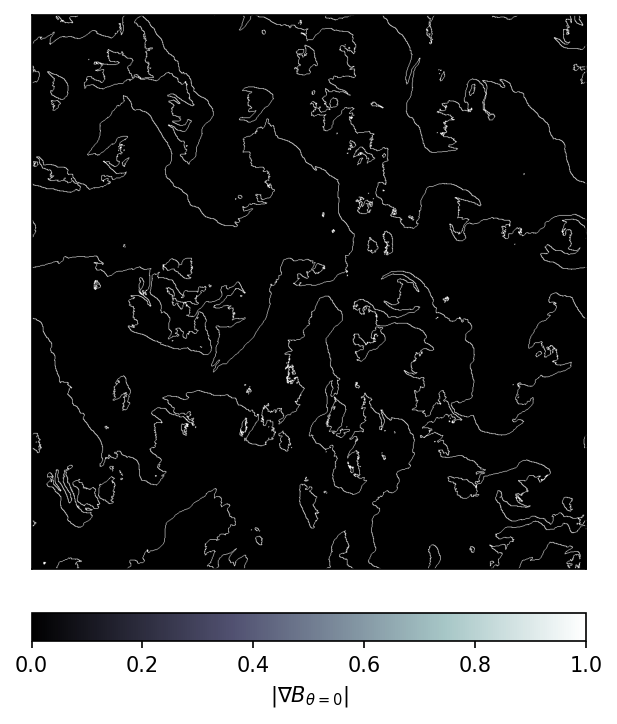

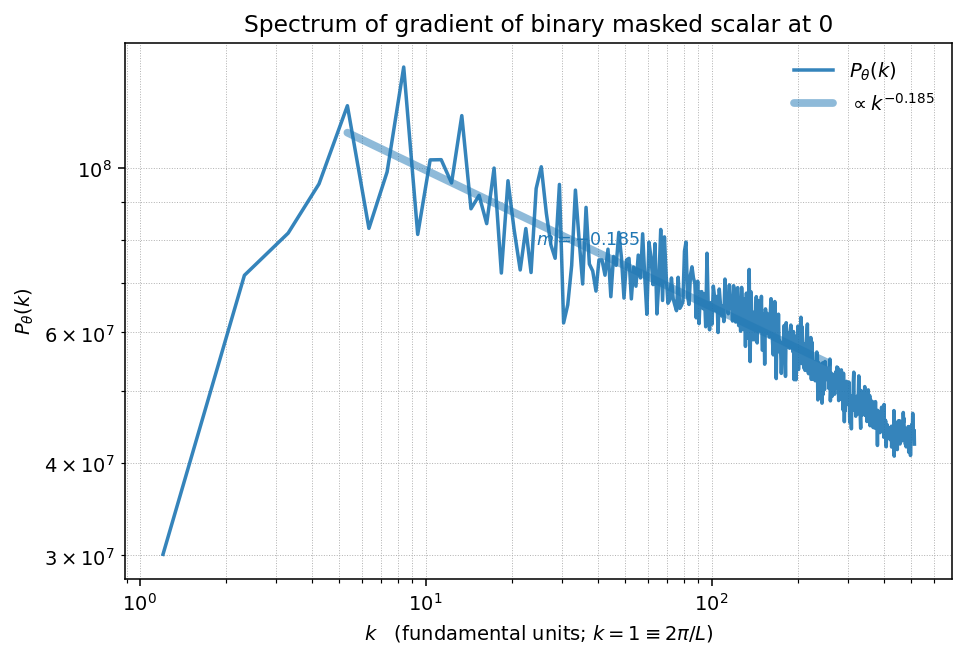

In [59]:
theta_masked = np.ones_like(theta_final)
theta_masked[theta_final<0] = 0
dtheta_masked = ((theta_masked - np.roll(theta_masked,1,axis=0))**2 + (theta_masked - np.roll(theta_masked,1,axis=1))**2)**0.5
dtheta_masked[dtheta_masked>0] = 1
fig, ax = plt.subplots(1,1, dpi=150, constrained_layout=True, figsize=(4,6))
im = ax.imshow(dtheta_masked, cmap='bone')
ax.set_xticks([])
ax.set_yticks([])
cb = plt.colorbar(im, location='bottom')
cb.set_label(r"$|\nabla B_{\theta=0}|$")
plt.show()


k_final, E_final = api.scalar_spectrum(dtheta_masked)
ScalarAdvectionAPI.plot_scalar_spectrum(
    k_final,
    E_final,
    title='Spectrum of gradient of binary masked scalar at 0',
    annotate_fit=True,
    fit_min_decades=1.2,
    fit_min_k=4.0,
    fit_max_k=k_final.max() / 2,
)

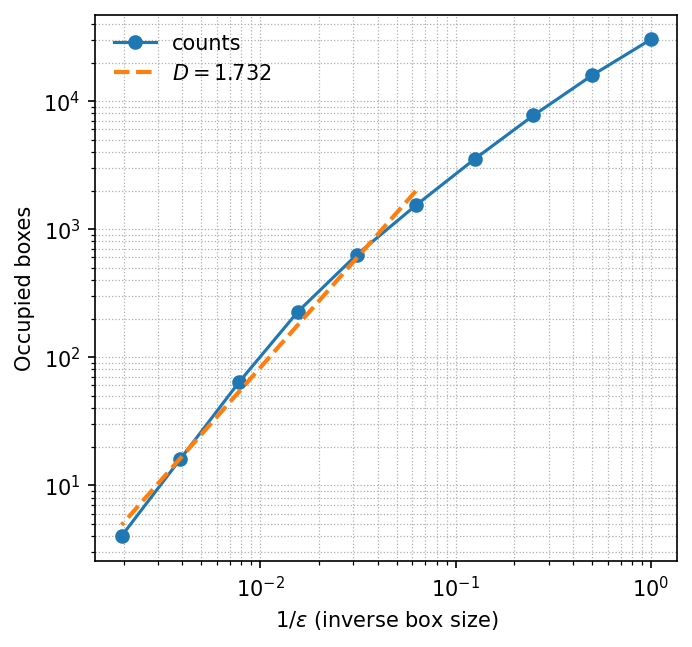

Box-counting fractal dimension D = 1.7323


In [ ]:
box_result = api.box_counting(
    dtheta_masked,
    min_box=1,
    max_box=N // 2,
    fit_min_size=8,
    fit_max_size=N//2,
    fit_min_decades=1.5
)
sizes = box_result.box_sizes.astype(float)
counts = box_result.counts
inv_sizes = 1.0 / sizes
fig, ax = plt.subplots(figsize=(4.5, 4.2), dpi=150, constrained_layout=True)
ax.loglog(inv_sizes, counts, 'o-', lw=1.5, label='counts')
if box_result.slope is not None and box_result.fit_indices is not None:
    i0, i1 = box_result.fit_indices
    x_fit = inv_sizes[i0:i1]
    slope = box_result.slope
    intercept = box_result.intercept
    ax.loglog(x_fit, 10**(intercept) * x_fit**slope, '--', lw=2, label=rf'$D={slope:.3f}$')
ax.set_xlabel(r'$1/\epsilon$ (inverse box size)')
ax.set_ylabel('Occupied boxes')
ax.grid(True, which='both', ls=':', lw=0.6)
ax.legend(frameon=False)
plt.show()
if box_result.slope is not None:
    print(f'Box-counting fractal dimension D = {box_result.slope:.4f}')
else:
    print('Box-counting fit unavailable (insufficient scale range).')